First part on accuracy.

Metrics such as:
- peptide recall/accuracy
- amino acid recall/accuracy

In [1]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm
from denovo_utils.io.read import load_psmlist
from itertools import chain


2025-08-18 13:57:40.073142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-18 13:57:40.093800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-18 13:57:40.100033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


Due to memory constraints, the notebook is run 3 times with different datasets seperately.

1. For clean samples: PXD028735

Selected runs:
[
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

A single PR curve is made for the results combined, 1 with peptide accuracy, the other with amino acid accuracy

Below, a barplot is created showing the total peptide accuracy (upper) and peptide recall (lower) for the datasets seperately.

2. For timsTOF or TTOF6600 data on clean samples: PXD028735 (Data not yet acquired)

Selected runs: Same set as in (1)

For now, results from metaproteomics can be shown acquired on a bruker instrument (TOF)

3. Metaproteomics sample (some S and F files)

A single PR curve for both S and F files combined, with 1 peptide accuracy and the other amino acid accuracy

Below, a barplot showing total peptide accuracy and recall for S and F samples seperately.

S samples are SIHUMIX and is a mock community. F samples an even more complex fecal sample.

In [319]:
from denovo_utils.io.read import load_psmlist

load_psmlist('/public/compomics3/Sam/PXD028735/QExactive/rescoring/LFQ_Orbitrap_DDA_Ecoli_01/psmlist/casanovo.instanovoplus.parquet')[0]['provenance_data']

100%|██████████| 61866/61866 [00:04<00:00, 12977.66it/s]


{'before_rescoring_score': -0.5462782979011536,
 'score_ms2rescore': -112.77850514293736}

In [323]:
load_psmlist('/public/compomics3/Sam/PXD028735/QExactive/rescoring/LFQ_Orbitrap_DDA_Ecoli_01/psmlist/casanovo.parquet')[0]['provenance_data']

100%|██████████| 61876/61876 [00:06<00:00, 9445.63it/s] 


{'before_rescoring_score': -0.5985946261457035,
 'score_ms2rescore': -6.81034736462222}

In [20]:
psm_list_in = load_psmlist(
    '/public/compomics3/Sam/PXD028735/QExactive/rescoring/LFQ_Orbitrap_DDA_Ecoli_01/psmlist/instanovo.parquet'
)

Loading results from instanovo.parquet: 100%|██████████| 62048/62048 [00:07<00:00, 7954.43it/s]


# 1. Read in the data

In [2]:
from denovo_utils.io.read import load_pickle

runs = load_pickle('/home/sam/Work_directory/DeNovo_Benchmark/notebooks/paper/s1_performance_benchmark/run_objects_7_8.pickle')

In [3]:
sum([len(i) for i in runs.values()])

186101

In [61]:
def get_ppms(spectrum):
    ppms = {}
    
    gt = spectrum.psm_gt
    for psm_candidate in spectrum.psm_candidates:
        ppms[psm_candidate.engine_name] = calculate_ppm(
            m1=psm_candidate.peptidoform.theoretical_mz,
            m2=gt.peptidoform.theoretical_mz,
            isotopes=[-1,0,1,2],
            charge=gt.peptidoform.precursor_charge
        )
    return ppms

In [63]:
ppms = []
for spectrum in tqdm(run.spectra.values()):
    ppms.append(get_ppms(spectrum))

100%|██████████| 41787/41787 [00:09<00:00, 4630.67it/s]


In [64]:
import pandas as pd
(pd.DataFrame(ppms)==50).melt().value_counts()

variable      value
instanovo     False    41289
contranovo    False    41214
novob         False    40770
pi-PrimeNovo  False    40487
casanovo      False    34588
AdaNovo       False    32320
pi-HelixNovo  False    31675
pepnet        False    23534
              True     18253
pi-HelixNovo  True     10112
AdaNovo       True      9467
casanovo      True      7199
pi-PrimeNovo  True      1300
novob         True      1017
contranovo    True       573
instanovo     True       498
dtype: int64

In [89]:
from copy import deepcopy

modifications = {
    'UNIMOD:35': [],
    'UNIMOD:1': [],
    'UNIMOD:385': [],
    'Q[UNIMOD:7]': [],
    'N[UNIMOD:7]': [],
    'UNIMOD:5': [],
    'Formula:H-2C1O1': []
}

modifications_per_run = {
    k: deepcopy(modifications) for k in runs.keys()
}

for run_name, run in runs.items():
    for spectrum_id, spectrum in run.spectra.items():
        modifications_ = modifications_per_run[run_name]
        gt_peptide = spectrum.psm_gt.peptidoform.modified_sequence
        for modification, l in modifications_.items():
            if modification in gt_peptide:
                l.append(spectrum_id)

In [90]:
{
    k: {k2: len(v2) for k2, v2 in v.items()}
    for k, v in modifications_per_run.items()
}

{'LFQ_Orbitrap_DDA_Ecoli_01': {'UNIMOD:35': 2757,
  'UNIMOD:1': 0,
  'UNIMOD:385': 6,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 15,
  'Formula:H-2C1O1': 2},
 'LFQ_Orbitrap_DDA_Human_01': {'UNIMOD:35': 8561,
  'UNIMOD:1': 115,
  'UNIMOD:385': 3,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 7,
  'Formula:H-2C1O1': 1},
 'LFQ_Orbitrap_DDA_QC_01': {'UNIMOD:35': 4704,
  'UNIMOD:1': 75,
  'UNIMOD:385': 6,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 8,
  'Formula:H-2C1O1': 2},
 'LFQ_Orbitrap_DDA_Yeast_01': {'UNIMOD:35': 5252,
  'UNIMOD:1': 55,
  'UNIMOD:385': 11,
  'Q[UNIMOD:7]': 0,
  'N[UNIMOD:7]': 0,
  'UNIMOD:5': 8,
  'Formula:H-2C1O1': 1}}

In [94]:
[i for i in spectrum.psm_candidates if i.engine_name != 'pepnet']

[{'peptidoform': Peptidoform('IPIIIR/2'), 'scores': {'peptide': {'AdaNovo': 0.9934163093566895, 'score_ms2rescore': 0.5075456910603475, 'Spectralis': -0.5536694941669924, 'InstaNovo+': -4.076769982930273e-05}, 'aa': {'AdaNovo': (0.98917, 0.99452, 0.99264, 0.98761, 0.99656, 0.9967)}}, 'engine_name': 'AdaNovo', 'peptide_evidence': LPLLLR/2, 'refinement': {'Spectralis': (None, True), 'InstaNovo+': (None, True)}, 'evaluation': {'score_ms2rescore': ('match', -0.472)}},
 {'peptidoform': Peptidoform('IPIIIR/2'), 'scores': {'peptide': {'pi-HelixNovo': 0.9800000190734863, 'score_ms2rescore': 0.5075456910603475, 'Spectralis': -0.5536694941669924, 'InstaNovo+': -4.085596447112039e-05}, 'aa': {}}, 'engine_name': 'pi-HelixNovo', 'peptide_evidence': LPLLLR/2, 'refinement': {'Spectralis': (None, True), 'InstaNovo+': (None, True)}, 'evaluation': {'score_ms2rescore': ('match', -0.472)}},
 {'peptidoform': Peptidoform('IPIIIR/2'), 'scores': {'peptide': {'pi-PrimeNovo': 0.9426490068435669, 'score_ms2resco

In [106]:
# Delete pepnet predictions for spectra with modifications outside pepnets search space
for run_name, run in runs.items():
    modified_spectra = set(chain(*list(modifications_per_run[run_name].values())))
    for spectrum_id, spectrum in run.spectra.items():
        if spectrum_id in modified_spectra:
            spectrum.psm_candidates = [i for i in spectrum.psm_candidates if i.engine_name != 'pepnet']

# 2. Peptide recall for common spectra, or based on db coverage

In [ ]:
for run in runs.values():
    for spectrum in run.spectra.values():
        spectrum.compare_gt(
            'sage',
            ignore_score=True
        )

In [3]:
denovo_engines = ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo', 'pi-PrimeNovo', 'AdaNovo', 'pi-HelixNovo']

In [8]:
test = get_match_score_table(
    {'LFQ_Orbitrap_DDA_Ecoli_01': runs['LFQ_Orbitrap_DDA_Ecoli_01'].get_common_spectra(engines=['instanovo'])},
    engine='instanovo',
    score_metadata='instanovo',
    eval_score_metadata='score_ms2rescore',
    refiner=None,
    return_table=True
)

In [100]:
import pandas as pd
def get_match_score_tables(runs, common_spectra=True):

    tables_by_run = {}
    for filename, run in runs.items():
        # print(filename)
        if common_spectra:
            run_engine = run.get_common_spectra(engines=denovo_engines)

        tables = {}
        for engine in denovo_engines:
            # print(engine)
            if not common_spectra:
                run_engine = run.get_common_spectra([engine])
            t = get_match_score_table(
                {filename: run_engine},
                engine=engine,
                score_metadata=engine,
                eval_score_metadata='score_ms2rescore',
                refiner=None,
                return_table=True
            )
            tables[engine] = t

        tables_by_run[filename] = tables
    
    pr_tables = {engine: [] for engine in denovo_engines}
    for filename, tables in tables_by_run.items():
        for engine, table in tables.items():
            pr_tables[engine].append(table)
    
    pr_tables = {engine: pd.concat(tables, ignore_index=True) for engine, tables in pr_tables.items()}
    return pr_tables

In [107]:
pr_tables_common_spectra = get_match_score_tables(runs=runs, common_spectra=True)
pr_tables_all_spectra = get_match_score_tables(runs=runs, common_spectra=False)

In [108]:
from denovo_utils.analysis.metrics import calculate_prc
import numpy as np

def calculate_prc(
        n_correct,
        n_selected,
        n_predicted
):
    c = n_correct
    ci = n_selected
    u = n_predicted - ci

    # precision
    precision = c/ci

    # recall (This is an alternative definition and the line will stop at x=y)
    recall = c/n_predicted

    # coverage
    coverage = ci/n_predicted

    return precision, recall, coverage


def get_prc_curve(t, n_predicted = None):
    prs = []
    recs = []
    covs = []

    t = t.sort_values('score', ascending=False).reset_index(drop=True)

    if n_predicted is None:
        n_predicted = len(t)

    for coverage in tqdm(np.linspace(0,1,200)):
        if coverage == 0:
            continue
        n_samples = coverage * len(t)
        samples_evaluated = t[t.index<n_samples]
        
        pr, rec, cov = calculate_prc(
            n_correct=len(samples_evaluated[samples_evaluated.match]),
            n_selected=len(samples_evaluated),
            n_predicted=n_predicted,
        )
        prs.append(pr)
        recs.append(rec)
        covs.append(cov)

    return pd.DataFrame(
        {'precision': prs,
         'recall': recs,
         'coverage': covs}
    )

In [109]:
# Calculate precision recall coverage when defined on common spectra
pr_rec_cov_dict = {}
for engine, tables in pr_tables_common_spectra.items():
    
    # total predicted here means all common spectra (shape of very df here)
    prc = get_prc_curve(tables)
    pr_rec_cov_dict[engine] = {
        'precision': prc.precision.to_numpy(),
        'recall': prc.recall.to_numpy(),
        'coverage': prc.coverage.to_numpy()
    }

# Calculate precision recall coverage on complete set of database results
# total predicted here means all db results
n_spectra = sum([len(i) for i in runs.values()])

all_db_peptides = sum([len(run.spectra.keys()) for run in runs.values()])
pr_rec_cov_dict_all = {}
for engine, tables in pr_tables_all_spectra.items():
    prc = get_prc_curve(tables, n_spectra)
    pr_rec_cov_dict_all[engine] = {
        'precision': prc.precision.to_numpy(),
        'recall': prc.recall.to_numpy(),
        'coverage': prc.coverage.to_numpy()
    }

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 118.00it/s]


Create the first PC plot on common spectra only to check performance on a common set irrespective whether some tool happens to not give a prediction to something

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


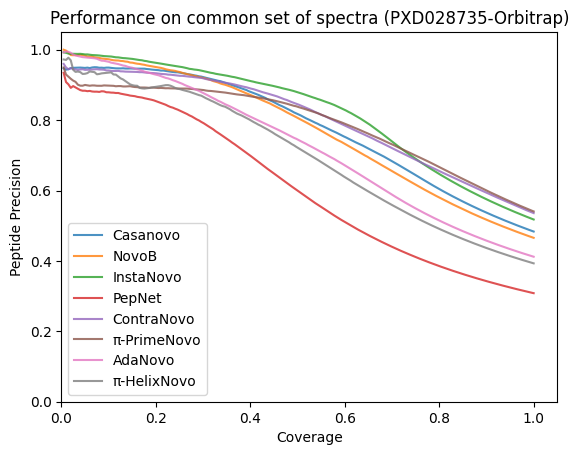

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


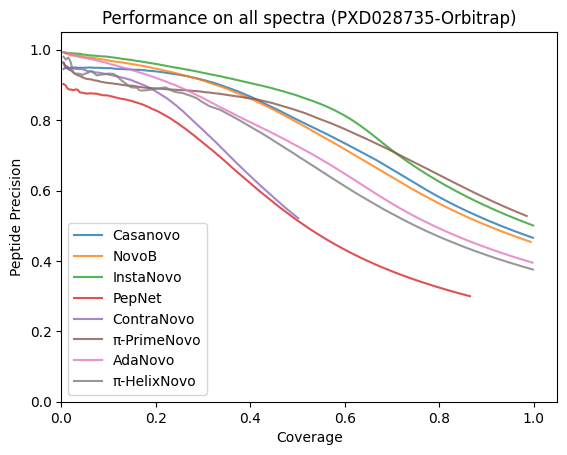

In [110]:
# AFter removing pepnet predictions outside its search space
# plotting a precision coverage curve
engine_labels = {
    'pepnet': 'PepNet',
    'novob': 'NovoB',
    'instanovo': 'InstaNovo',
    'casanovo': 'Casanovo',
    'contranovo': 'ContraNovo',
    'AdaNovo': 'AdaNovo',
    'pi-PrimeNovo': 'π-PrimeNovo',
    'pi-HelixNovo': 'π-HelixNovo'
}

for engine, pr_dict in pr_rec_cov_dict.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine_labels[engine],   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')
plt.show()

# plotting a precision coverage curve
engine_labels = {
    'pepnet': 'PepNet',
    'novob': 'NovoB',
    'instanovo': 'InstaNovo',
    'casanovo': 'Casanovo',
    'contranovo': 'ContraNovo',
    'AdaNovo': 'AdaNovo',
    'pi-PrimeNovo': 'π-PrimeNovo',
    'pi-HelixNovo': 'π-HelixNovo'
}

for engine, pr_dict in pr_rec_cov_dict_all.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine_labels[engine],   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on all spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')
plt.show()

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


Text(0, 0.5, 'Peptide Precision')

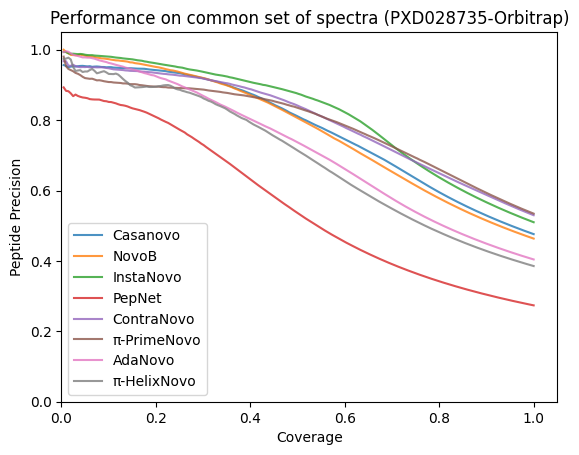

In [ ]:
# plotting a precision coverage curve
engine_labels = {
    'pepnet': 'PepNet',
    'novob': 'NovoB',
    'instanovo': 'InstaNovo',
    'casanovo': 'Casanovo',
    'contranovo': 'ContraNovo',
    'AdaNovo': 'AdaNovo',
    'pi-PrimeNovo': 'π-PrimeNovo',
    'pi-HelixNovo': 'π-HelixNovo'
}

for engine, pr_dict in pr_rec_cov_dict.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine_labels[engine],   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

# plotting a precision coverage curve
engine_labels = {
    'pepnet': 'PepNet',
    'novob': 'NovoB',
    'instanovo': 'InstaNovo',
    'casanovo': 'Casanovo',
    'contranovo': 'ContraNovo',
    'AdaNovo': 'AdaNovo',
    'pi-PrimeNovo': 'π-PrimeNovo',
    'pi-HelixNovo': 'π-HelixNovo'
}

for engine, pr_dict in pr_rec_cov_dict_all.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine_labels[engine],   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on all spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


Text(0, 0.5, 'Peptide Precision')

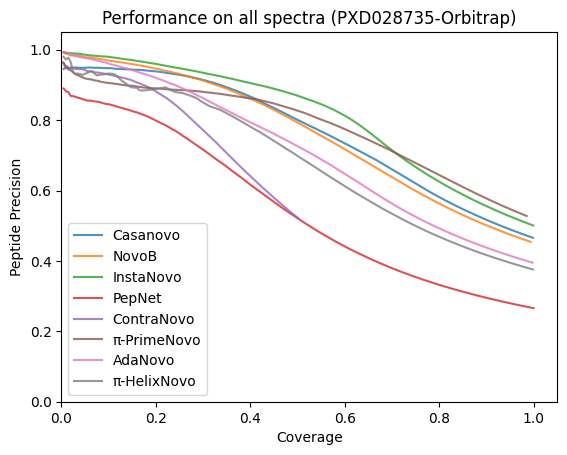

In [70]:
runs

{'LFQ_Orbitrap_DDA_Ecoli_01': 15982 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).,
 'LFQ_Orbitrap_DDA_Human_01': 65856 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).,
 'LFQ_Orbitrap_DDA_QC_01': 61132 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).,
 'LFQ_Orbitrap_DDA_Yeast_01': 43131 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).}

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


Text(0, 0.5, 'Peptide Precision')

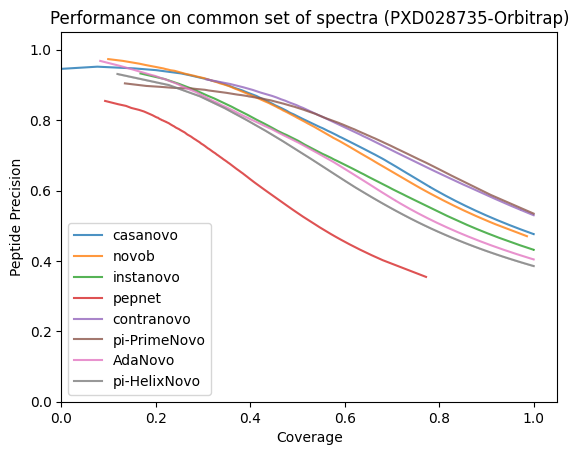

In [14]:
# plotting a precision coverage curve
for engine, pr_dict in pr_rec_cov_dict.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

In [16]:
from denovo_utils.parsers import DenovoEngineConverter

parser = DenovoEngineConverter.select('instanovo')
psmlist = parser.parse(
    result_path='/public/compomics3/Sam/PXD028735/QExactive/denovo_output/instanovo/LFQ_Orbitrap_DDA_Ecoli_01.instanovo.csv',
    mgf_path='/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted/LFQ_Orbitrap_DDA_Ecoli_01.mgf'
)

Parsing Instanovo results to PSMList: 100%|██████████| 60613/60613 [00:02<00:00, 25743.90it/s]


In [17]:
psmlist[psmlist['spectrum_id']=='controllerType=0 controllerNumber=1 scan=10014']

PSMList(
    psm_list=[
        PSM(
            peptidoform=Peptidoform('LAQEASQEAAR/2'),
            spectrum_id='controllerType=0 controllerNumber=1 scan=10014',
            run='LFQ_Orbitrap_DDA_Ecoli_01.instanovo.csv',
            collection=None,
            spectrum=None,
            is_decoy=None,
            score=-0.6346168518066406,
            qvalue=None,
            pep=None,
            precursor_mz=587.296725797435,
            retention_time=32.012793,
            ion_mobility=None,
            protein_list=None,
            rank=1,
            source='InstaNovo',
            provenance_data={},
            metadata={
                'scan_number': '1396',
                'aa_scores': '[-0.02476981095969677, -0.009171617217361927, -0.00010895135346800089, -0.001191621064208448, -2.455681169521995e-05, -2.5629668016335927e-05, -0.023111147806048393, -0.0009472650708630681, -0.02187633514404297, -0.0069465795531868935, -0.5463126301765442]'
            },
            res

In [15]:
runs['LFQ_Orbitrap_DDA_Ecoli_01'].spectra['controllerType=0 controllerNumber=1 scan=10014']

Spectrum ID: controllerType=0 controllerNumber=1 scan=10014
Ground-truth: LAQEASQE<AA>R/2 ({'peptide': {'sage': 2.7397043704986572, 'score_ms2rescore': 2.7397043704986572}, 'aa': {}})
Candidates:
	LAQEASAGE<AA>R/2 ({'peptide': {'AdaNovo': 0.9181580543518066, 'score_ms2rescore': 2.5012912759266137, 'Spectralis': -0.9695392307695376, 'InstaNovo+': -0.003537328215315938}, 'aa': {'AdaNovo': (0.46272, 0.95038, 0.95715, 0.9377, 0.95856, 0.95908, 0.95905, 0.95907, 0.95883, 0.95629, 0.95906, 0.95908)}})
	VYADT<ALM[UNIMOD:35]><GT>K/2 ({'peptide': {'pi-HelixNovo': 0.8100000023841858, 'score_ms2rescore': -8.30218178534406, 'Spectralis': -2.008333469505214, 'InstaNovo+': -0.01644195429980755}, 'aa': {}})
	LAQE<SQ>AE<AA>R/2 ({'peptide': {'pi-PrimeNovo': 0.0013102841330692172, 'score_ms2rescore': 1.7548339113503673, 'Spectralis': -1.5367428330958304, 'InstaNovo+': -0.00034771833452396095}, 'aa': {}})
	LAQEASQE<AA>R/2 ({'peptide': {'casanovo': 0.9010915756225586, 'score_ms2rescore': 2.739704253114398

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


Text(0, 0.5, 'Peptide Precision')

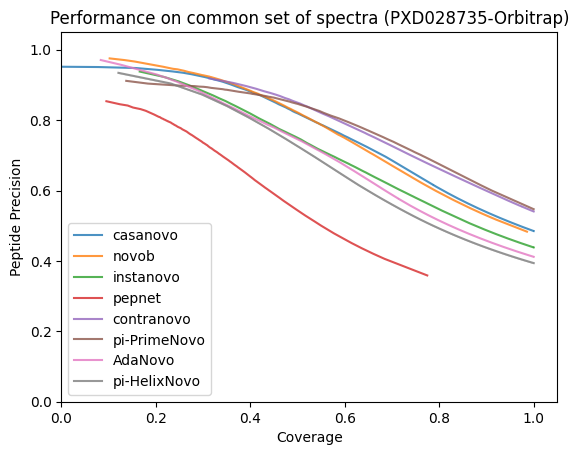

In [129]:
# plotting a precision coverage curve
for engine, pr_dict in pr_rec_cov_dict.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


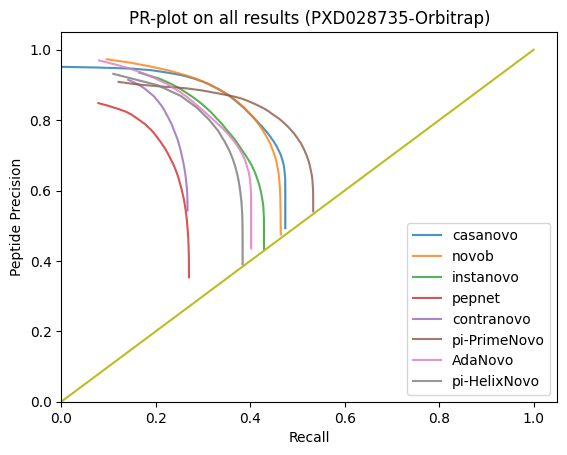

In [137]:
# Create the precision recall curve where recall means correct/n_database_results, which equals precision when all predictions are considered
for engine, pr_dict in pr_rec_cov_dict_all.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["recall"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("PR-plot on all results (PXD028735-Orbitrap)")
plt.xlabel('Recall')
plt.ylabel('Peptide Precision')
plt.plot((0,1), (0,1))

# 3. Barplots showing Precision and Coverage by sample type

In [213]:
barplot_data = {
    'engine': [],
    'run': [],
    'precision': [],
    'coverage': []
}

for engine in denovo_engines:
    engine_performance = {}

    for run_name, run in runs.items():

        n_all = len(run.spectra)
        run_engine = run.get_common_spectra(engines=[engine])
        n_predicted = len(run_engine.spectra)
        n_correct = 0
        for spectrum in run_engine.spectra.values():
            psm = spectrum.get_psms_by_engine(engine)[0]
            if psm.evaluation['sage'].error_type=="match":
                n_correct += 1

        coverage = n_predicted/n_all
        precision = n_correct/n_predicted
        
        barplot_data['coverage'].append(coverage)
        barplot_data['precision'].append(precision)
        barplot_data['engine'].append(engine)
        barplot_data['run'].append(run_name)

In [233]:
barplot_data = pd.DataFrame(barplot_data).sort_values(by='precision')

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_precision_coverage_barplot(barplot_data):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the first barchart (pointing to the right)
    bar1 = sns.barplot(data=barplot_data, y='run', x='precision', hue='engine', ax=ax)

    # Plot the second barchart (pointing to the left)
    bar2 = sns.barplot(data=barplot_data, y='run', x=[-v for v in barplot_data['coverage']], hue='engine', ax=ax)

    # Add the vertical line at x=0
    ax.axvline(0, color='black', linewidth=1)

    # Customize the plot
    ax.set_ylabel('Sample type')

    # Set x-axis limits to ensure symmetry
    max_val = max(max(barplot_data['precision']), max(barplot_data['coverage']))
    ax.set_xlim(-int(max_val), int(max_val))
    ax.set_xticks(range(-int(max_val), int(max_val) + 1, 5))

    # Remove default x-axis label
    ax.set_xlabel('')

    # Add custom x-axis labels for Precision and Coverage
    ax.text(max_val / 2, -0.7, 'Precision', va='center', ha='center', fontsize=12)
    ax.text(-max_val / 2, -0.7, 'Coverage', va='center', ha='center', fontsize=12)

    # Adjust the legend to appear outside the plot
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict(zip(labels, handles)).items())
    ax.legend(
        [handle for _, handle in unique_labels],
        [label for label, _ in unique_labels],
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        title="De novo tool"
    )

    for p in bar1.patches:
        width = p.get_width()  # Get the width of the bar
        percentage = (width / max_val) * 100  # Calculate the percentage of max width
        ax.annotate(f'{abs(percentage):.2f}%', (p.get_width(), p.get_y() + p.get_height() / 2),
                    va='center', ha='left', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()


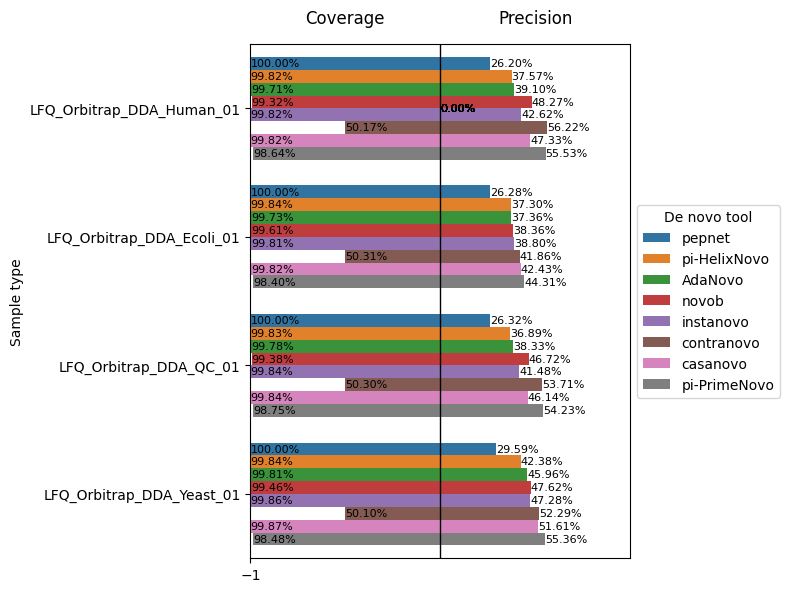

In [237]:
plot_precision_coverage_barplot(barplot_data)

## 3. Amino acid recall/coverage

Accuracy = correct / predictions above threshold
Recall = correct / n_amino_acids in ground truth

In [313]:
from denovo_utils.analysis.metrics import aa_match, convert_peptidoform
import numpy as np

aa_engines = ['contranovo', 'AdaNovo', 'casanovo', 'pepnet']

aa_pr_engine = {}

total_aa_gt_counted = False
total_aa_gt = 0

for run in runs.values():
    for spectrum in run.spectra.values():
        total_aa_gt += len(spectrum.psm_gt.peptidoform)
        if spectrum.psm_gt.peptidoform.properties['n_term'] is not None:
            total_aa_gt += 1


for engine in aa_engines:
    print(engine)
    run_engine = run.get_common_spectra([engine])

    scores_aa = []
    match_aa = []
    for run in runs.values():
        for spectrum in tqdm(run_engine.spectra.values()):
            psm_gt = spectrum.psm_gt
            psm_dn = spectrum.get_psms_by_engine(engine)[0]
            scores = list(psm_dn.scores.get_score(metadata=engine, score_type='aa'))

            _, pep_match, (match_1, match_2), iso_errs, tols = aa_match(
                convert_peptidoform(psm_dn.peptidoform),
                convert_peptidoform(psm_gt.peptidoform),
                aa_dict={}
            )


            if engine == 'contranovo':
                while len(scores) != len(match_1):
                    n_term_score = np.mean(scores[:2])
                    scores = scores[1::]
                    scores[0] = n_term_score
            
            assert len(match_1) == len(scores)
            scores_aa += scores
            match_aa += match_1.tolist()
           
    tables_df = pd.DataFrame(
        {'score': scores_aa, 'match': match_aa}
    )
    aa_pr_engine[engine] = get_prc_curve(
        tables_df,
        total_predicted=total_aa_gt
    )

contranovo


100%|██████████| 20936/20936 [00:01<00:00, 14509.79it/s]
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


AdaNovo


100%|██████████| 41709/41709 [00:03<00:00, 13326.83it/s]
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


casanovo


100%|██████████| 41734/41734 [00:02<00:00, 14461.07it/s]
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


pepnet


100%|██████████| 41787/41787 [00:03<00:00, 12335.44it/s]
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


plotting contranovo
plotting AdaNovo
plotting casanovo
plotting pepnet


Text(0, 0.5, 'Amino Acid Precision')

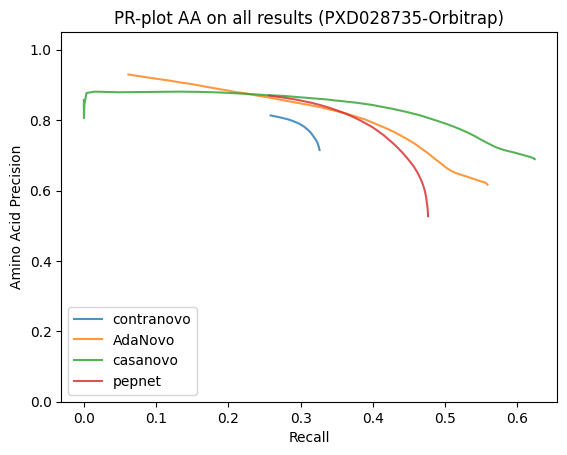

In [314]:
# Create the precision recall curve where recall means correct/n_database_results, which equals precision when all predictions are considered
for engine, pr_dict in aa_pr_engine.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["recall"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.ylim((0,1.05))
plt.title("PR-plot AA on all results (PXD028735-Orbitrap)")
plt.xlabel('Recall')
plt.ylabel('Amino Acid Precision')